In [ ]:
mfrom google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Input, BatchNormalization, Dropout, MaxPool2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torch
import os


In [ ]:
path = "/content/drive/MyDrive/Mixed Images"
filenames = os.listdir(path)

df=pd.DataFrame({'filename':filenames})
df["category"] = df.apply(lambda x: x['filename'].split('_')[0], axis=1)

temp1 = df[df.category=='Damaged']
temp2 = df[df.category=='Undamaged']
df = pd.concat([temp1, temp2],ignore_index=True, axis = 0)
df.category.value_counts()

train_df, validate_df = train_test_split(df, test_size=0.30, random_state=42, stratify=df["category"])
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42, stratify=validate_df["category"])

#resetting the index
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [ ]:
print(train_df.category.value_counts())
print(validate_df.category.value_counts())
print(test_df.category.value_counts())

Damaged      1090
Undamaged    1053
Name: category, dtype: int64
Damaged      233
Undamaged    226
Name: category, dtype: int64
Damaged      234
Undamaged    226
Name: category, dtype: int64


In [ ]:
cnn= tf.keras.models.Sequential()

#first convolution
cnn.add(tf.keras.layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu',input_shape=[224,224,3]))
cnn.add(BatchNormalization())
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(Dropout(0.2))

#second convolution layer
cnn.add(tf.keras.layers.Conv2D(filters=512,kernel_size=(3,3),activation='relu'))
cnn.add(BatchNormalization())
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(Dropout(0.2))

#third convolution layer
cnn.add(tf.keras.layers.Conv2D(filters=512,kernel_size=(3,3),activation='relu'))
cnn.add(BatchNormalization())
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(Dropout(0.2))

#fourth convolution layer
cnn.add(tf.keras.layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu'))
cnn.add(BatchNormalization())
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(Dropout(0.2))

cnn.add(tf.keras.layers.Flatten())
cnn.add(Dropout(0.2))

#fully connected layer
cnn.add(tf.keras.layers.Dense(128,activation='relu'))
cnn.add(Dropout(0.5))

#output layer
cnn.add(tf.keras.layers.Dense(units=len(train_df.category.value_counts()),activation='softmax'))

In [ ]:
train_datagen = ImageDataGenerator( rotation_range=15,
                                    rescale=1./255,
                                    shear_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip = True,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1)

train_set = train_datagen.flow_from_dataframe(train_df,path,x_col='filename',y_col='category',
                                              target_size=(224, 224),class_mode='categorical',batch_size=32)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_set = validation_datagen.flow_from_dataframe(validate_df,path,x_col='filename',
                                                        y_col='category',target_size=(224, 224),
                                                        class_mode='categorical',batch_size=32)

test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_dataframe(test_df,path,x_col='filename',
                                            y_col='category',target_size=(224, 224),
                                            class_mode='categorical',batch_size=32, shuffle=False)

Found 2143 validated image filenames belonging to 2 classes.
Found 459 validated image filenames belonging to 2 classes.
Found 460 validated image filenames belonging to 2 classes.


In [ ]:
cnn.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-04), metrics=['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 256)     7168      
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 256)     1024      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 256)     0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 256)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 512)     1180160   
_________________________________________________________________
batch_normalization_1 (Batch (None, 109, 109, 512)     2048      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 512)       0

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)

r = cnn.fit(train_set, 
            validation_data=validation_set,
            epochs=15,
            steps_per_epoch=len(train_set),
            validation_steps=len(validation_set),
            callbacks=callback)

Epoch 1/15
67/67 [==============================] - 1755s 26s/step - loss: 1.0522 - accuracy: 0.5315 - val_loss: 0.7682 - val_accuracy: 0.4924
Epoch 2/15
67/67 [==============================] - 1739s 26s/step - loss: 0.6961 - accuracy: 0.5674 - val_loss: 0.8911 - val_accuracy: 0.4924
Epoch 3/15
67/67 [==============================] - 1754s 26s/step - loss: 0.6912 - accuracy: 0.5688 - val_loss: 0.7655 - val_accuracy: 0.4967
Epoch 4/15
67/67 [==============================] - 1721s 26s/step - loss: 0.6727 - accuracy: 0.5894 - val_loss: 0.8737 - val_accuracy: 0.5163
Epoch 5/15
67/67 [==============================] - 1746s 26s/step - loss: 0.6724 - accuracy: 0.5847 - val_loss: 0.7901 - val_accuracy: 0.5294
Epoch 6/15
67/67 [==============================] - ETA: 0s - loss: 0.6605 - accuracy: 0.5894 

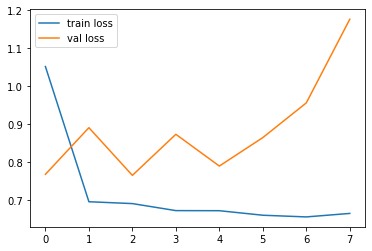

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/CNN_ValLoss_2.png')
plt.show()

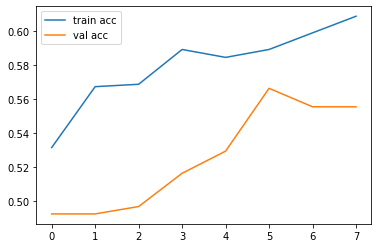

In [ ]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('/content/drive/MyDrive/CNN_ValACC_2.png')
plt.show()

In [ ]:
train_set.class_indices.items()

dict_items([('Damaged', 0), ('Undamaged', 1)])

In [ ]:
cnn.save('/content/drive/MyDrive/CNN100.h5')

In [ ]:
cnn = tf.keras.models.load_model('/content/drive/MyDrive/CNN.h5')
test_set.reset()
pred = cnn.predict(test_set)
test_df["pred"] = np.argmax(pred, axis=1)
test_df["pred"] = test_df["pred"].replace({0:'Damaged',1:'Undamaged'})
test_df.tail()

,filename,category,pred
455,Damaged_0539.JPG,Damaged,Damaged
456,Damaged_0267.JPG,Damaged,Undamaged
457,Undamaged_1299.JPG,Undamaged,Undamaged
458,Damaged_1083.JPG,Damaged,Undamaged
459,Damaged_1485.JPG,Damaged,Undamaged


In [ ]:
test_df.to_csv("/content/drive/MyDrive/test_df.csv")

In [ ]:
cnn.evaluate(test_set, verbose=2)

15/15 - 143s - loss: 0.7036 - accuracy: 0.5783


[0.703611433506012, 0.5782608985900879]

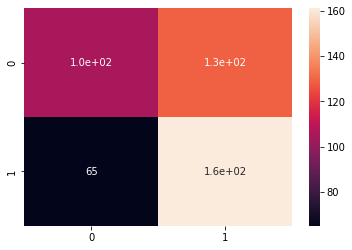

In [ ]:
cm = confusion_matrix(test_df['category'], test_df['pred'])
sns.heatmap(cm, annot=True)

In [ ]:
target_names = ['Damaged','Undamaged']
classification_report(test_df['category'], test_df['pred'], target_names= target_names)

'              precision    recall  f1-score   support\n\n     Damaged       0.62      0.45      0.52       234\n   Undamaged       0.56      0.71      0.62       226\n\n    accuracy                           0.58       460\n   macro avg       0.59      0.58      0.57       460\nweighted avg       0.59      0.58      0.57       460\n'

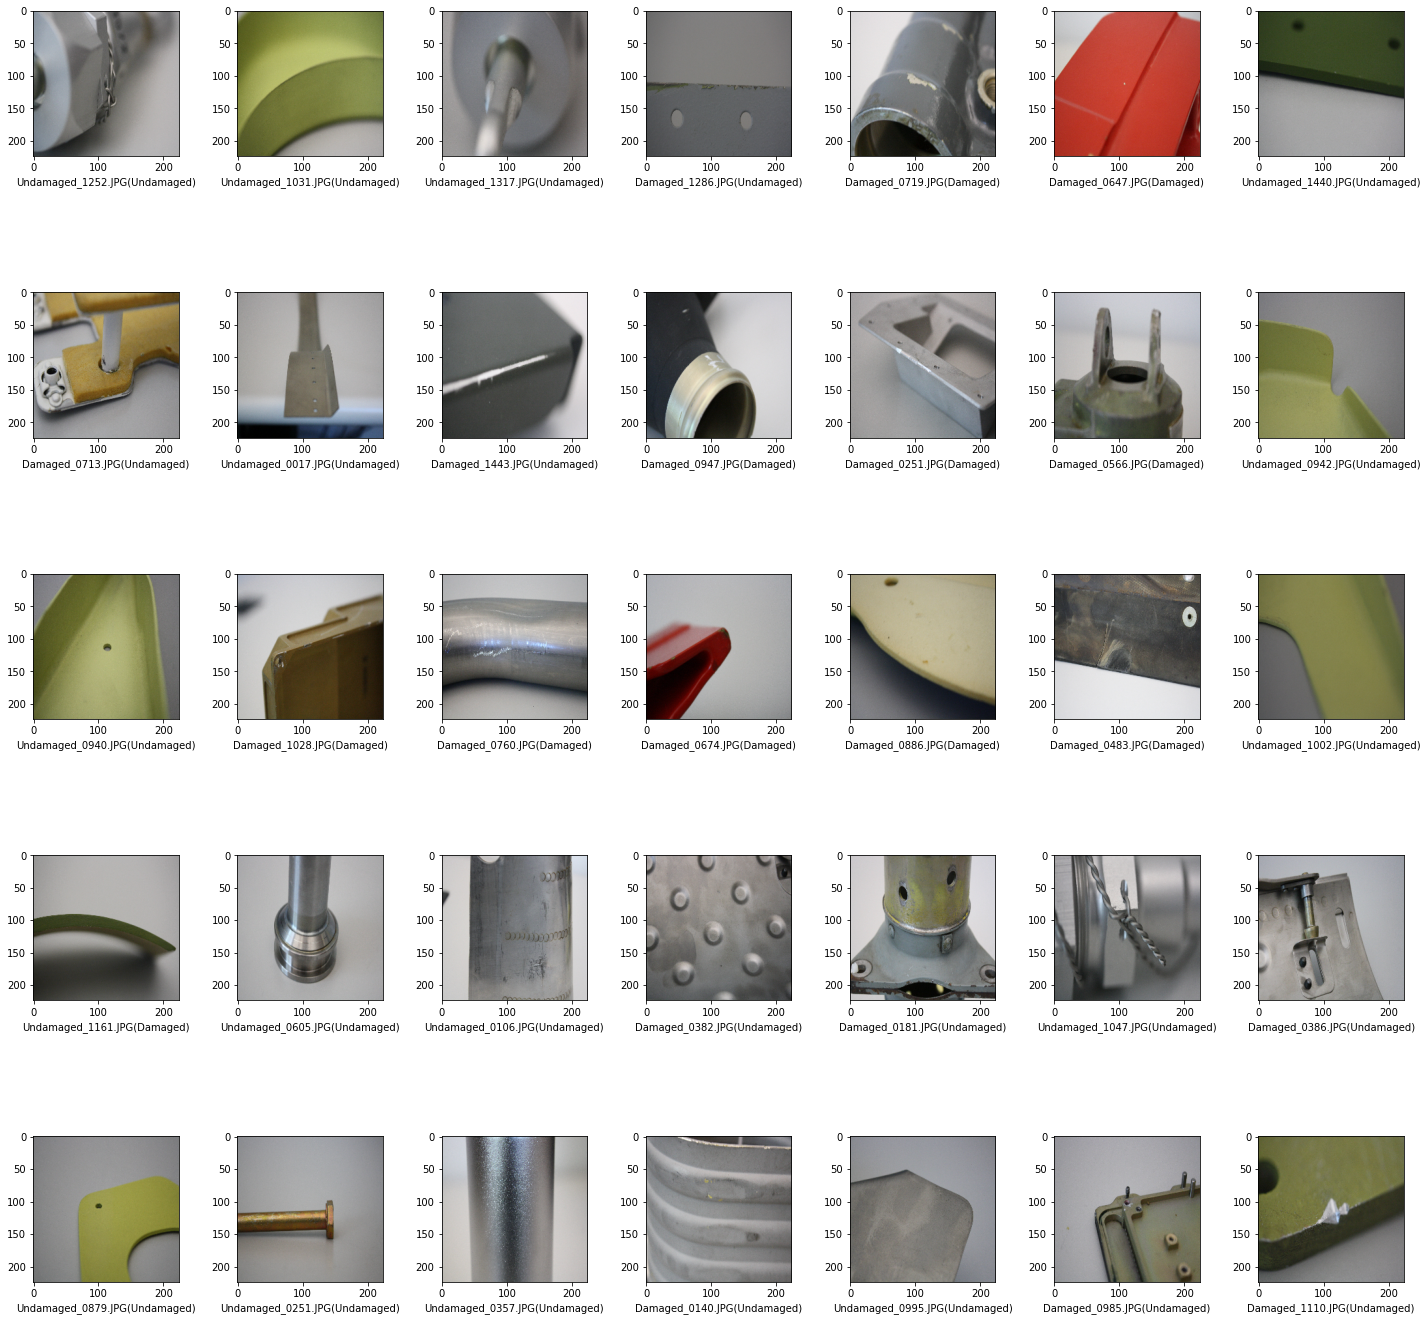

In [ ]:
from keras.preprocessing import image

sample_test = test_df.sample(n=35).reset_index(drop=True)
plt.figure(figsize=(20, 20))
for index, row in sample_test.iterrows():
    filename = row['filename']
    pred = row['pred']
    img = image.load_img(path + "/" + filename, target_size=(224,224))
    plt.subplot(5, 7, index+1)
    plt.imshow(img)
    plt.xlabel(filename.split(' ')[0] + '(' + "{}".format(pred) + ')' )
plt.tight_layout()
plt.show()

Found 1 validated image filenames belonging to 1 classes.


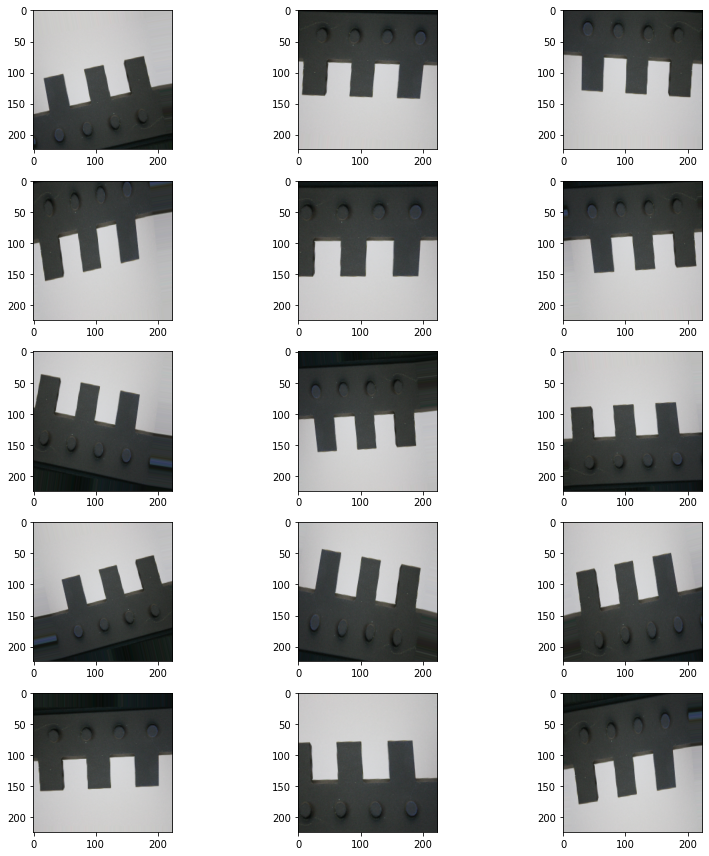

In [ ]:
# Image Augmentation
example_df = train_df.sample(n=1).reset_index(drop=True)
example_set = train_datagen.flow_from_dataframe(
    example_df, 
    path, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical'
)

plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_set:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()